In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import random
import glob
import cv2

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv("../input/lgg-mri-segmentation/kaggle_3m/data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
df.describe()

,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
count,92.000000,109.000000,110.000000,108.000000,98.000000,105.000000,110.000000,109.000000,109.000000,109.0,109.000000,109.000000,109.000000,109.000000,108.000000,102.000000,109.000000
mean,2.445652,3.678899,1.900000,1.722222,2.367347,1.895238,1.763636,2.128440,1.532110,1.0,2.009174,3.513761,1.486239,45.834862,2.907407,1.970588,0.247706
std,1.180092,1.169684,0.789263,0.862872,1.125045,0.663960,0.855927,0.850935,0.501273,0.0,0.995317,1.863960,0.502119,13.797151,0.291212,0.169792,0.433674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,20.000000,2.000000,1.000000,0.000000
25%,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,2.000000,1.000000,34.000000,3.000000,2.000000,0.000000
50%,2.000000,4.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.0,2.000000,2.000000,1.000000,47.000000,3.000000,2.000000,0.000000
75%,4.000000,5.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.0,3.000000,6.000000,2.000000,58.000000,3.000000,2.000000,0.000000
max,4.000000,5.000000,4.000000,3.000000,4.000000,3.000000,3.000000,3.000000,2.000000,1.0,3.000000,6.000000,2.000000,75.000000,3.000000,2.000000,1.000000


In [5]:
df.isna().sum()

Patient                       0
RNASeqCluster                18
MethylationCluster            1
miRNACluster                  0
CNCluster                     2
RPPACluster                  12
OncosignCluster               5
COCCluster                    0
histological_type             1
neoplasm_histologic_grade     1
tumor_tissue_site             1
laterality                    1
tumor_location                1
gender                        1
age_at_initial_pathologic     1
race                          2
ethnicity                     8
death01                       1
dtype: int64

In [6]:
df.drop(["tumor_tissue_site"],axis=1 , inplace=True)

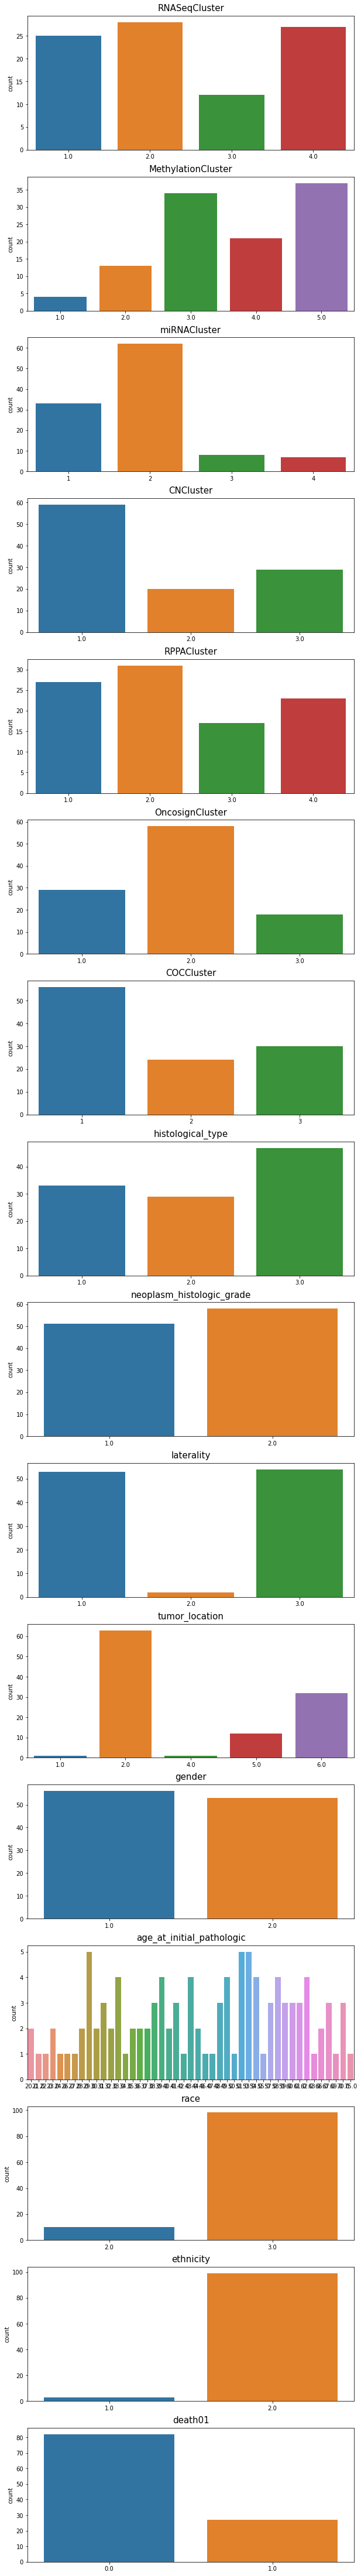

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,axes = plt.subplots(nrows=16, ncols=1, figsize=(10,80))
for i in range(17):
    col  = df.columns[i]
    count = sns.countplot(x=col, data=df, ax=axes[i-1])
    axes[i-1].set_title(col, fontsize=15, y=1.01)
    axes[i-1].set_xlabel(None)
plt.show()

In [8]:
# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

In [9]:
# Masks/Not masks
data_map = []
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"
for sub_dir_path in glob.glob(DATA_PATH+"*"):
#     print(sub_dir_path)
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)


This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


In [10]:
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_18.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_18_mask.tif


In [11]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df.to_csv('./lgg_diagnosis.csv')



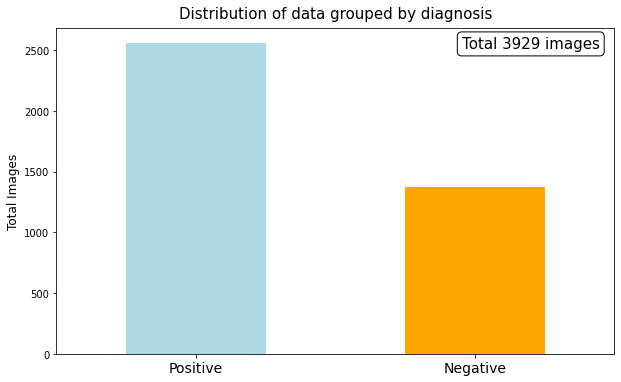

In [12]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["lightblue", "orange"])

ax.set_xticklabels(["Positive", "Negative"], rotation=0, fontsize=14);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 15,y=1.01)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("white"),
                   ec=("black"),
                   )
         );